## Boilerplate and Imports

In [1]:
#Needed imports and boilerplate
from glob import glob
import afidutils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.patches as mpatches
from scipy.stats import wilcoxon
from tabulate import tabulate
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV,Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GroupKFold 

# Used for filtering AFIDs
exclude_afids = ['CULx','PGx','GENUx', 'SPLEx', 'ALTHx', 'SAMTHx', 'IAMTHx', 'IGOx','VOHx','OSFx',
                 'CULy','PGy','GENUy', 'SPLEy', 'ALTHy', 'SAMTHy', 'IAMTHy', 'IGOy','VOHy','OSFy',
                 'CULz','PGz','GENUz', 'SPLEz', 'ALTHz', 'SAMTHz', 'IAMTHz', 'IGOz','VOHz','OSFz'
                ]


#Analysis Parameters 
midpoint='PMJ' #assign a midpoint for ACPC transformation

# STN model Path
model_path = '/Users/alaataha/Documents/GitHub/afids-pred/resources/models/afids_stn_model_all_data.pkl'

#To make plots look sharper
%config InlineBackend.figure_format = 'retina'

## 1. Robustness to Annotation Variability

In [2]:
def compute_rater_annotation_errors(mni_gt_afids_df, df_afids):
    """
    Compute rater annotation errors as Euclidean distances between ground truth AFIDs and raters' AFIDs.
    
    Parameters:
    - mni_gt_afids_df (pd.DataFrame): DataFrame with ground truth AFID coordinates (1 row, 96 columns: x_1...z_32)
    - df_afids (pd.DataFrame): DataFrame with rater AFID coordinates (same column structure as mni_gt_afids_df)
    - output_prefix (str): Prefix for output CSV files (e.g., 'EDs' will produce 'EDs.csv' and 'EDs_xyzdiff.csv')
    
    Returns:
    - euclidean_distances (pd.DataFrame): DataFrame of Euclidean distances per AFID
    - xyzdiff (pd.DataFrame): DataFrame of raw coordinate differences
    """
    
    # Get ground truth coordinates (assumes first row)
    mni = mni_gt_afids_df.iloc[0]
    xyzdiff = df_afids - mni 

    # Initialize an empty dataframe to store the Euclidean distances
    euclidean_distances = pd.DataFrame(index=xyzdiff.index)

    # Compute Euclidean distances for each AFID
    for i in range(1, 33):
        x_col = f'x_{i}'
        y_col = f'y_{i}'
        z_col = f'z_{i}'
        euclidean_distances[i] = np.sqrt(
            xyzdiff[x_col]**2 + xyzdiff[y_col]**2 + xyzdiff[z_col]**2
        )
    return euclidean_distances, xyzdiff

In [3]:
# Load AFID coordiante data
mni_fcsv = sorted(glob(f'/Users/alaataha/Documents/GitHub/afids-pred/resources/MNI152NLin2009bAsym/afids_mcp/sub-MNI152NLin2009bAsym/anat/*desc-rater*.fcsv'))
mni_afids_gt = '/Users/alaataha/Documents/GitHub/afids-pred/resources/MNI152NLin2009bAsym/afids_mcp/sub-MNI152NLin2009bAsym/anat/sub-MNI152NLin2009bAsym_space-MCPPMJ_desc-groundtruth_afids.fcsv'
mni_stn_gt = '/Users/alaataha/Documents/GitHub/afids-pred/resources/MNI152NLin2009bAsym/stn_mcp/sub-MNI152NLin2009bAsym/anat/sub-MNI152NLin2009bAsym_space-MCPPMJ_desc-groundtruth_stn.fcsv'
print(f'Number of AFID annotations on MNI: {len(mni_fcsv)}')

Number of AFID annotations on MNI: 38


In [4]:
# Convert FCSV files into pandas DataFrames and associate them with datasets
dfs = []         # List to store individual AFID DataFrames
dataset = []     # List to store corresponding dataset names
for afid_file in mni_fcsv:
    dfs.append(afidutils.fcsvtodf(afid_file)[0])  # Convert the .fcsv file into a DataFrame
    dataset.append(afidutils.extract_sub_metadata(afid_file)[2])  # Extract dataset name from file path
# Combine all subject DataFrames into one master DataFrame
df_afids = pd.concat(dfs, axis=0)

In [5]:
# Mirror left STN x-coordinates
mni_gt_stn_df = afidutils.fcsvtodf(mni_stn_gt)[0]
mni_gt_stn_df.columns = ['RSTNx', 'LSTNx', 'RSTNy', 'LSTNy', 'RSTNz', 'LSTNz']
mni_gt_stn_df['LSTNx'] *= -1
df_stn_r = mni_gt_stn_df[['RSTNx', 'RSTNy', 'RSTNz']].rename(columns=lambda c: c[1:])
df_stn_l = mni_gt_stn_df[['LSTNx', 'LSTNy', 'LSTNz']].rename(columns=lambda c: c[1:])
df_stn_proc = pd.concat([df_stn_r, df_stn_l], axis=0)
stn_true = df_stn_proc.to_numpy()

In [6]:
# Put Rater Data in DataFrames
mni_gt_afids_df = afidutils.fcsvtodf(mni_afids_gt)[0]

euclidean_distances = compute_rater_annotation_errors(mni_gt_afids_df, df_afids)[0]

results = []

annotation_errors = euclidean_distances.drop(afidutils.exclude_afids_labels,axis=1)

for f, mni_file in enumerate(mni_fcsv):
    pred = afidutils.predict_stn_coordinates(mni_file, model_path)  # shape: (2, 3)
    for i, side in enumerate(['R', 'L']):
        diff = pred[i] - stn_true[i]
        ed = np.linalg.norm(diff)
        annotation_error_mean = float(annotation_errors.iloc[f, :].mean())
        results.append({
            "file": mni_file,
            "side": side,
            "meanAFLE": annotation_error_mean,
            "prediction_error": ed
        })

results_df = pd.DataFrame(results)

/var/folders/1_/pqzl0fjs2595xmp99j42cvmc0000gn/T/ipykernel_95946/1204770869.py:12: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



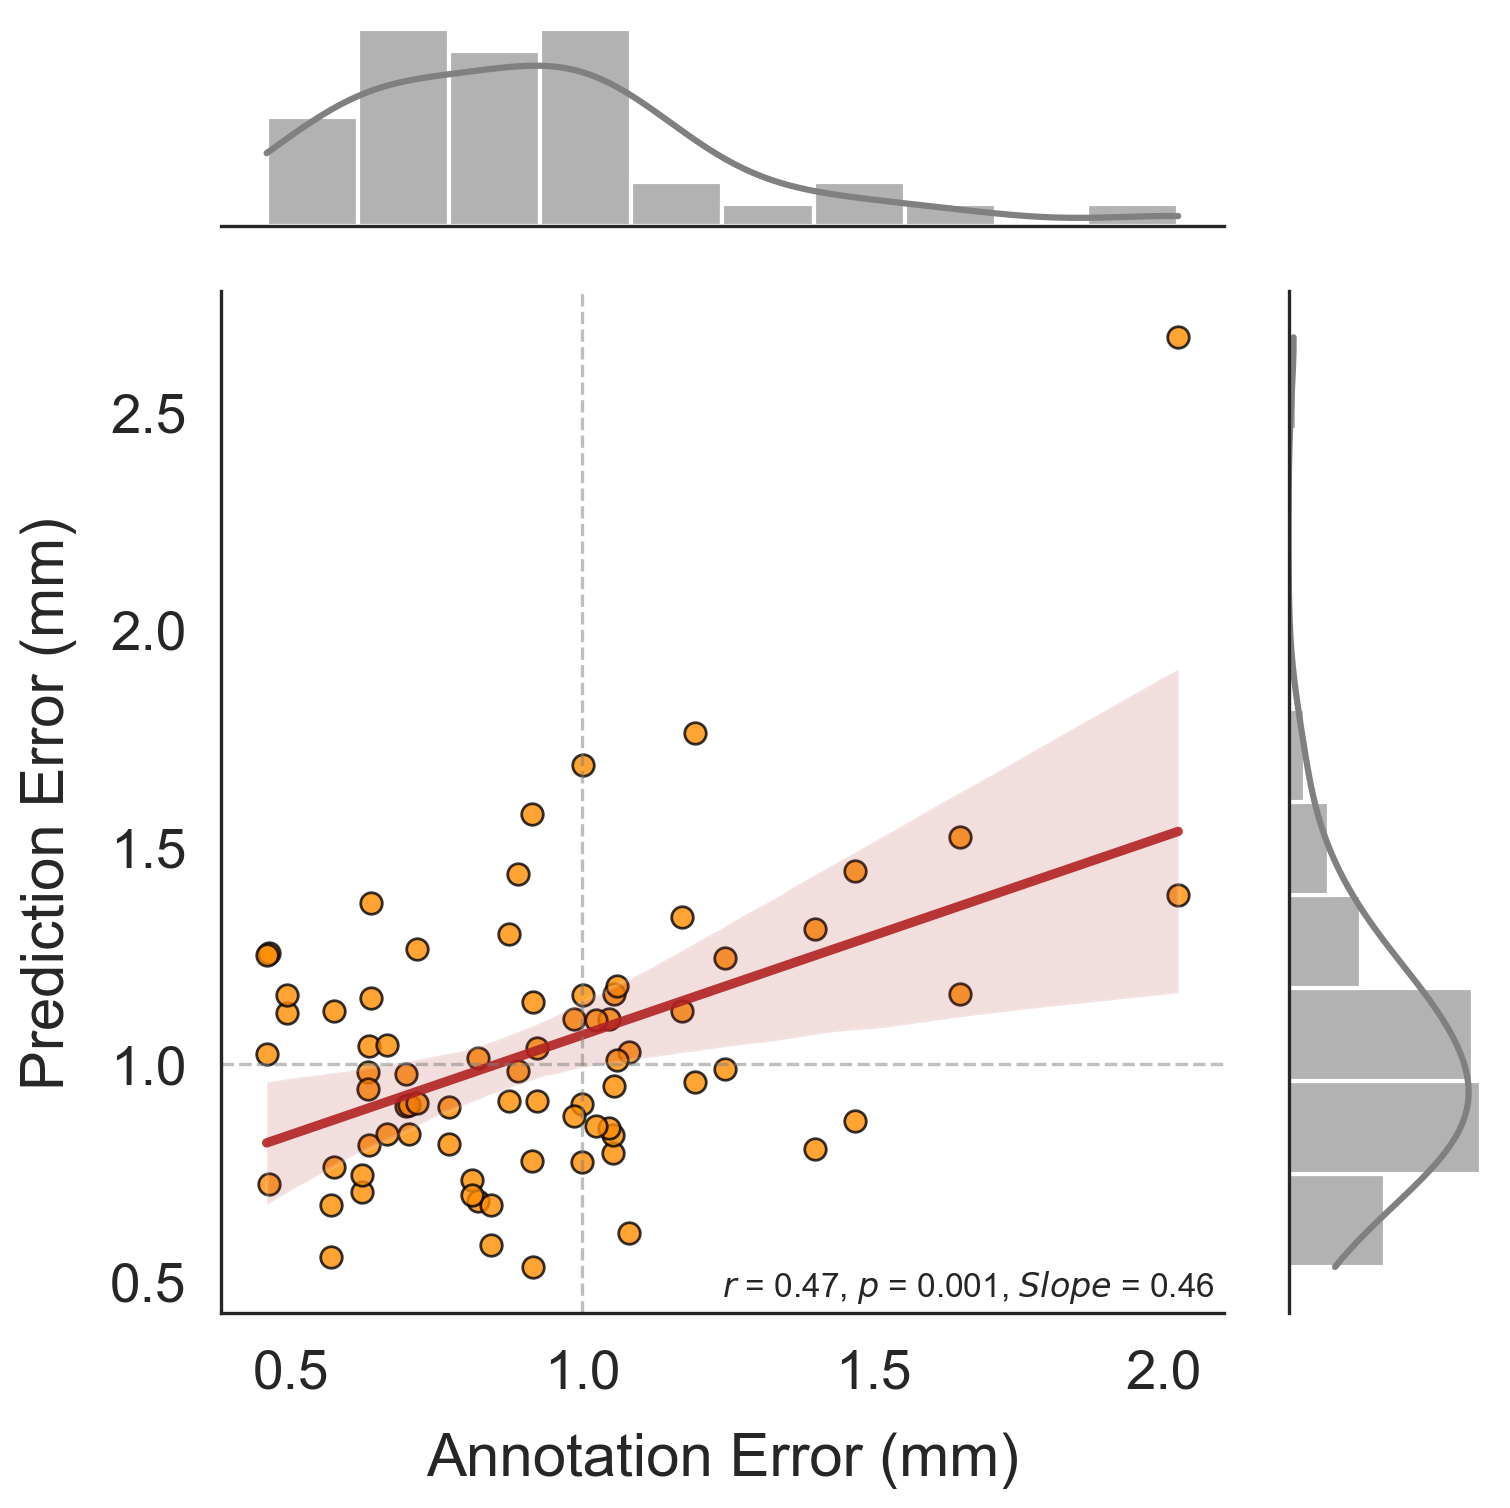

In [7]:
combined_df = results_df
# Compute Pearson correlation between annotation error and prediction error
corr_navg, p_navg = pearsonr(combined_df["meanAFLE"], combined_df["prediction_error"])
# Set seaborn and matplotlib styles for a clean, publication-ready look
sns.set(style="white", context="talk", font_scale=1.2)
mpl.rcParams['axes.linewidth'] = 1.2  # thicker axis lines

# Fit linear regression using statsmodels
X_avg = sm.add_constant(combined_df["meanAFLE"])
y_avg = combined_df["prediction_error"]
avg_model = sm.OLS(y_avg, X_avg).fit()
slope_avg = avg_model.params[1]
within_1mm_avg = (combined_df["prediction_error"] <= 1.0).mean() * 100
max_pred_error_avg = combined_df["prediction_error"].max()

# Create jointplot with KDE marginals and regression line
g = sns.jointplot(
    data=combined_df,
    x="meanAFLE",
    y="prediction_error",
    kind="reg",
    height=8,
    ratio=4,  # makes marginal plots thinner
    space=0.1,
    scatter_kws={"s": 60, "alpha": 0.8, "color": "darkorange", "edgecolor": "black"},
    line_kws={"color": "firebrick", "alpha": 0.9},
    marginal_kws={"bins": 10, "fill": True, "color": "gray", "alpha": 0.6}
)

# Add threshold lines at 1.0 mm for visual reference
g.ax_joint.axhline(1.0, linestyle='--', color='gray', alpha=0.5, linewidth=1.2)
g.ax_joint.axvline(1.0, linestyle='--', color='gray', alpha=0.5, linewidth=1.2)

# Axis labels
g.set_axis_labels("Annotation Error (mm)", "Prediction Error (mm)", labelpad=12)

# Customize spines (remove top and right)
for spine in ["top", "right"]:
    g.ax_joint.spines[spine].set_visible(False)

# Add a stat summary box on the joint plot
g.ax_joint.text(
    0.5, -0.02,
    f"$r$ = {corr_navg:.2f}, $p$ = 0.001, $Slope$ = {slope_avg:.2f}\n" ,
    transform=g.ax_joint.transAxes,
    fontsize=12,
)


# Tight layout and save
plt.tight_layout()
g.figure.savefig("/Users/alaataha/Documents/GitHub/afids-pred/figures/Prediction_Error_and_Annotation_Error_jointplot.png", dpi=300)
plt.show()

## 2. Generalization to Other Imaging Modalities

In [2]:
# Path to test data CSV containing subject IDs
test_csv_path = "/Users/alaataha/Documents/GitHub/afids-pred/data/coordinate/test_data.csv"
test_subids = pd.read_csv(test_csv_path)
coords_path = "/Users/alaataha/Documents/GitHub/afids-pred/data/coordinate"
# Initialize containers for subject IDs, predictions, and ground truths
subsindex = []
predictions = []
groundtruths = []
dataset = [] 

# Iterate over each subject ID in the test dataset
for subjectid in test_subids['subjid'].to_list():
    # Locate the AFIDs ground truth file for the subject
    afids_fcsv = sorted(glob(
        f"{coords_path}/AFIDs/*/afids_mcp/{subjectid}/anat/{subjectid}_space-MCPPMJ_desc-groundtruth_afids.fcsv"))[0]

    # Predict STN coordinates using the trained model
    subjprediction = afidutils.predict_stn_coordinates(afids_fcsv, model_path)
    predictions.append(subjprediction)

    # Determine STN ground truth file path based on scanner metadata
    scanner_type = afidutils.extract_sub_metadata(afids_fcsv)[-2]
    dataset.extend([scanner_type,scanner_type])
    
    if scanner_type == '3T7T_3T':
        stn_path = subjectid.replace('sub-', 'sub-R')
    elif scanner_type == 'SNSXPD1.5T':
        stn_path = subjectid.replace('sub-R', 'sub-P')
    else:
        stn_path = subjectid

    stn_fcsv = sorted(glob(
        f"{coords_path}/STN/*/stn_mcp/{stn_path}/*/*MCP*.fcsv"))[0]

    # Load and process STN ground truth coordinates
    df_stn = afidutils.fcsvtodf(stn_fcsv)[0]
    df_stn.columns = ['RSTNx', 'LSTNx', 'RSTNy', 'LSTNy', 'RSTNz', 'LSTNz']

    # Mirror left STN x-coordinates for alignment
    df_stn['LSTNx'] *= -1

    # Add subject ID twice (once for each hemisphere)
    subsindex.extend([stn_path, stn_path])

    # Reformat right and left STN coordinates to common schema
    df_stn_r = df_stn[['RSTNx', 'RSTNy', 'RSTNz']].rename(columns=lambda c: c[1:])
    df_stn_l = df_stn[['LSTNx', 'LSTNy', 'LSTNz']].rename(columns=lambda c: c[1:])
    df_stn_proc = pd.concat([df_stn_r, df_stn_l], axis=0).to_numpy()

    groundtruths.append(df_stn_proc)

# Stack all predictions and ground truth coordinates vertically
pred_coords = np.vstack(predictions)    # Shape: (N, 3), where N = 2 * number of subjects
gt_coords = np.vstack(groundtruths)     # Same shape as pred_coords

# Create DataFrames for further analysis
df_pred = pd.DataFrame(pred_coords, columns=['STNx', 'STNy', 'STNz'])
df_gt = pd.DataFrame(gt_coords, columns=['STNx', 'STNy', 'STNz'])

# Compute differences
delta = (df_pred - df_gt)**2
delta.columns = ['MSEx', 'MSEy', 'MSEz']  # Rename difference columns

# Compute Euclidean Distance
delta['ED'] = np.sqrt(delta['MSEx'] + delta['MSEy'] + delta['MSEz'])
delta['dataset'] = dataset
delta['subjectid']=subsindex

In [3]:
delta.describe()

,MSEx,MSEy,MSEz,ED
count,80.000000,80.000000,80.000000,80.000000
mean,0.453847,0.655029,0.480633,1.181958
std,0.560245,0.785148,0.585445,0.441498
min,0.000442,0.000502,0.000003,0.146611
25%,0.052548,0.065235,0.033178,0.835419
50%,0.185310,0.386232,0.292743,1.195184
75%,0.684479,0.950246,0.710977,1.527132
max,2.430507,3.750998,2.766225,2.115560


In [4]:
def compute_stats(df_1, df_2, list_of_medthods):
    metrics = ["MSEx", "MSEy", "MSEz", "ED"]
    summary_tables = []
    test_results = []

    # Summary stats for each dataframe
    summary_1 = df_1[metrics].describe().T
    summary_1["dataset"] = list_of_medthods[0]
    summary_2 = df_2[metrics].describe().T
    summary_2["dataset"] = list_of_medthods[1]

    summary_all = pd.concat([summary_1, summary_2])
    summary_all.reset_index(inplace=True)
    summary_all.rename(columns={"index": "metric"}, inplace=True)

    # Wilcoxon test results
    for metric in metrics:
        method2 = df_1[metric].values
        method1 = df_2[metric].values
        diff = np.round(method2 - method1, 3)
        stat, p = wilcoxon(diff)
        test_results.append({
            "metric": metric,
            "test": "Wilcoxon",
            "statistic": stat,
            "p_uncorrected": p
        })

    test_results_df = pd.DataFrame(test_results)

    return summary_all, test_results_df

In [5]:
# Assign hemispheres based on row order
def assign_hemisphere(df):
    df = df.copy()
    df['hemisphere'] = df.groupby("subjectid").cumcount().map({0: "R", 1: "L"})
    return df

# Load data
df = delta

# Prepare MRI-gad vs MRI-nogad
df_snsxpd = assign_hemisphere(df[df["dataset"] == "SNSXPD"])
df_snsxpd1_5t = assign_hemisphere(df[df["dataset"] == "SNSXPD1.5T"])
df_snsxpd["modality"] = "7T MRI-nogad"
df_snsxpd1_5t["modality"] = "1.5T MRI-gad"
df_snsxpd["comparison"] = "1.5T MRI-gad vs 7T MRI-nogad"
df_snsxpd1_5t["comparison"] = "1.5T MRI-gad vs 7T MRI-nogad"

# Prepare 3T vs 7T
df_3t = assign_hemisphere(df[df["dataset"] == "3T7T_3T"])
df_7t = assign_hemisphere(df[df["dataset"] == "3T7T_7T"])
df_3t["modality"] = "3T"
df_7t["modality"] = "7T"
df_3t["comparison"] = "3T vs 7T"
df_7t["comparison"] = "3T vs 7T"

# Combine everything
df_all = pd.concat([df_snsxpd1_5t,df_snsxpd, df_3t, df_7t], ignore_index=True)

In [6]:
summary_table, test_table = compute_stats(df_snsxpd1_5t, df_snsxpd, ['1.5T MRI-gad','7T MRI-nogad'])

print("=== Summary Statistics ===")
print(tabulate(summary_table, headers='keys', tablefmt='grid', showindex=False))

print("\n=== Wilcoxon Test Results ===")
print(tabulate(test_table, headers='keys', tablefmt='grid', showindex=False))

=== Summary Statistics ===
+----------+---------+----------+----------+-------------+-----------+----------+----------+---------+--------------+
| metric   |   count |     mean |      std |         min |       25% |      50% |      75% |     max | dataset      |
+==========+=========+==========+==========+=============+===========+==========+==========+=========+==============+
| MSEx     |      20 | 0.487967 | 0.57906  | 0.0160577   | 0.0903686 | 0.240767 | 0.684479 | 1.91326 | 1.5T MRI-gad |
+----------+---------+----------+----------+-------------+-----------+----------+----------+---------+--------------+
| MSEy     |      20 | 0.743625 | 0.873849 | 0.00132073  | 0.0831546 | 0.799483 | 0.929074 | 3.751   | 1.5T MRI-gad |
+----------+---------+----------+----------+-------------+-----------+----------+----------+---------+--------------+
| MSEz     |      20 | 0.602753 | 0.581371 | 0.0120126   | 0.114414  | 0.574448 | 0.791012 | 2.0023  | 1.5T MRI-gad |
+----------+---------+-------

In [7]:
summary_table, test_table = compute_stats(df_3t, df_7t, ['3T','7T'])
print("=== Summary Statistics ===")
print(tabulate(summary_table, headers='keys', tablefmt='grid', showindex=False))

print("\n=== Wilcoxon Test Results ===")
print(tabulate(test_table, headers='keys', tablefmt='grid', showindex=False))

=== Summary Statistics ===
+----------+---------+----------+----------+-------------+-----------+-----------+----------+---------+-----------+
| metric   |   count |     mean |      std |         min |       25% |       50% |      75% |     max | dataset   |
+==========+=========+==========+==========+=============+===========+===========+==========+=========+===========+
| MSEx     |      20 | 0.394356 | 0.574997 | 0.000441881 | 0.0547871 | 0.101068  | 0.440807 | 1.7337  | 3T        |
+----------+---------+----------+----------+-------------+-----------+-----------+----------+---------+-----------+
| MSEy     |      20 | 0.679529 | 0.759728 | 0.000501778 | 0.0600475 | 0.434574  | 1.29761  | 2.34671 | 3T        |
+----------+---------+----------+----------+-------------+-----------+-----------+----------+---------+-----------+
| MSEz     |      20 | 0.47527  | 0.776287 | 2.83621e-06 | 0.0241562 | 0.0657581 | 0.650846 | 2.76623 | 3T        |
+----------+---------+----------+----------+-

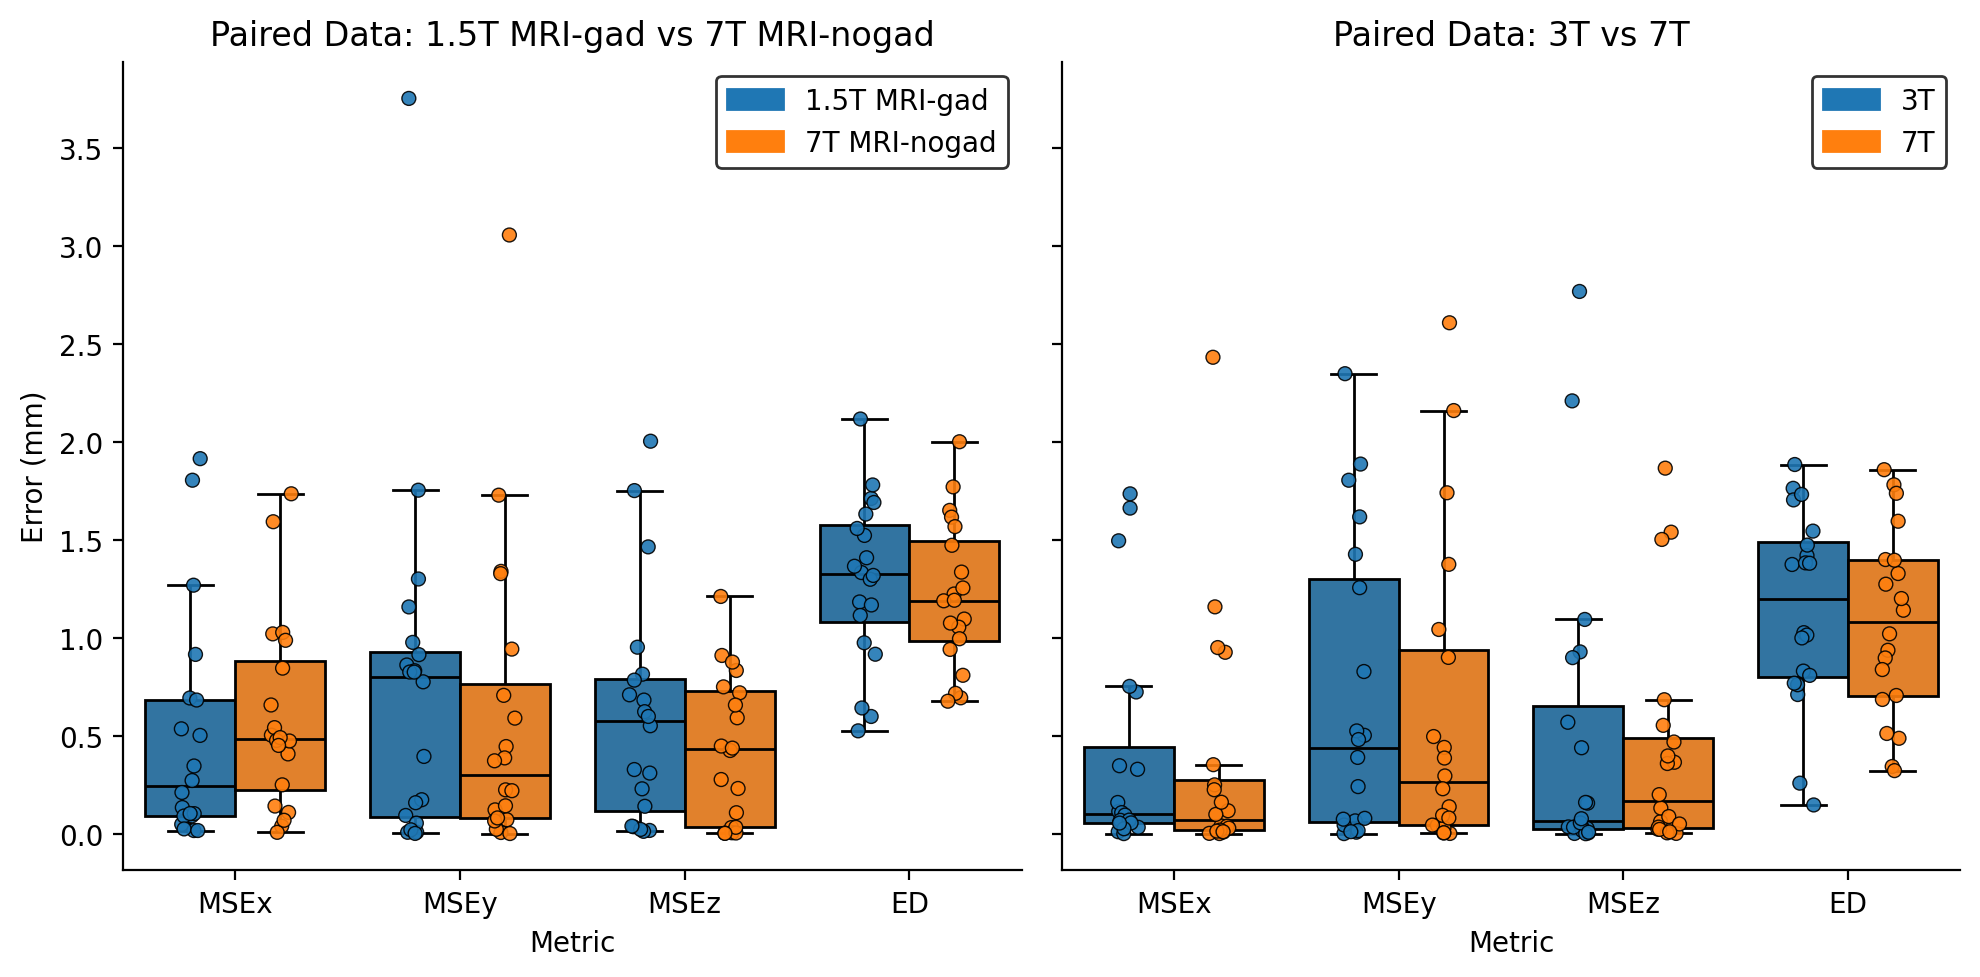

In [8]:
# Compute stats for each comparison
summary1, pvals_gad = compute_stats(df_snsxpd1_5t, df_snsxpd, ['1.5T MRI-gad','7T MRI-nogad'])
summary2, pvals_3t7t = compute_stats(df_3t, df_7t, ['3T','7T'])

# Combine into one dictionary for easy lookup
pval_dict = {
    "1.5T MRI-gad vs 7T MRI-nogad": pvals_gad.set_index("metric")["p_uncorrected"].to_dict(),
    "3T vs 7T": pvals_3t7t.set_index("metric")["p_uncorrected"].to_dict()
}

# Melt for plotting
melted_all = pd.melt(
    df_all,
    id_vars=["subjectid", "hemisphere", "modality", "comparison"],
    value_vars=["MSEx", "MSEy", "MSEz", "ED"],
    var_name="metric",
    value_name="error"
)

# Plotting

# Define color mapping for modalities
modality_colors = {
    "1.5T MRI-gad": "#1f77b4",   # blue
    "7T MRI-nogad": "#ff7f0e", # orange
    "3T": "#1f77b4",        # blue
    "7T": "#ff7f0e"         # orange
}


g = sns.FacetGrid(melted_all, col="comparison", height=5, aspect=1, sharey=True)
g.map_dataframe(sns.boxplot, 
                x="metric", 
                y="error", 
                hue="modality", 
                palette=modality_colors, 
                fliersize=0, 
                boxprops=dict(edgecolor='black'),
                whiskerprops=dict(color='black'),
                capprops=dict(color='black'),
                medianprops=dict(color='black'))

g.map_dataframe(sns.stripplot, 
                x="metric", 
                y="error", 
                hue="modality", 
                palette=modality_colors, 
                dodge=True, 
                alpha=0.9, 
                jitter=True, 
                linewidth=0.5, 
                edgecolor='black')

g.set_axis_labels("Metric", "Error (mm)")

# Manual legends per subplot
for ax, title in zip(g.axes.flat, g.col_names):
    ax.set_title(f"Paired Data: {title}")
    if title == "1.5T MRI-gad vs 7T MRI-nogad":
        handles = [
            mpatches.Patch(color=modality_colors['1.5T MRI-gad'], label="1.5T MRI-gad"),
            mpatches.Patch(color=modality_colors['7T MRI-nogad'], label="7T MRI-nogad")
        ]
    else:
        handles = [
            mpatches.Patch(color=modality_colors['3T'], label="3T"),
            mpatches.Patch(color=modality_colors['7T'], label="7T")
        ]
    legend = ax.legend(handles=handles, loc="upper right")
    legend.get_frame().set_edgecolor('black') 
    
    
    # Annotate p-values
    metrics = ["MSEx", "MSEy", "MSEz", "ED"]
    for i, metric in enumerate(metrics):
        p = pval_dict[title][metric]
        text = f"p = {p:.3e}" if p < 0.05/4 else ""
        ax.text(i, ax.get_ylim()[1] * 0.8, text,
                ha='center', va='top', fontsize=10, color='black')
plt.tight_layout()
plt.savefig('/Users/alaataha/Documents/GitHub/afids-pred/figures/Model_Error_Multimodal.png',dpi = 300)
plt.show()


In [9]:
melted_all_ed = melted_all[melted_all['metric'] == 'ED']
melted_all_ed.describe()


,error
count,80.000000
mean,1.181958
std,0.441498
min,0.146611
25%,0.835419
50%,1.195184
75%,1.527132
max,2.115560


## 4. Benchmarking

In [10]:
# Load Registration Data
stn_lead_dfs = []
stn_fcsv_lead = sorted(glob("/Users/alaataha/Documents/GitHub/afids-pred/resources/LeadDBS/*/stn_mcp/sub-*/anat/sub-*MCPPMJ*.fcsv"))
dataset = []
# Load and process STN ground truth coordinates
for lead in stn_fcsv_lead:
    if "SNSXPD1.5T" in lead: 
        dataset.append("SNSXPD1.5T")
        dataset.append("SNSXPD1.5T")
    else:
        dataset.append("SNSXPD")
        dataset.append("SNSXPD")

    df_stn_lead = afidutils.fcsvtodf(lead)[0]
    df_stn_lead.columns = ['RSTNx', 'LSTNx', 'RSTNy', 'LSTNy', 'RSTNz', 'LSTNz']

    # Mirror left STN x-coordinates for alignment
    df_stn_lead['LSTNx'] *= -1

    # Reformat right and left STN coordinates to common schema
    df_stn_r_lead = df_stn_lead[['RSTNx', 'RSTNy', 'RSTNz']].rename(columns=lambda c: c[1:])
    df_stn_l_lead = df_stn_lead[['LSTNx', 'LSTNy', 'LSTNz']].rename(columns=lambda c: c[1:])
    df_stn_proc_lead = pd.concat([df_stn_r_lead, df_stn_l_lead], axis=0).to_numpy()

    stn_lead_dfs.append(df_stn_proc_lead)
    
lead_preds = np.vstack(stn_lead_dfs)
lead_preds_df = pd.DataFrame(lead_preds, columns=['STNx', 'STNy', 'STNz'])

In [11]:
df_gt_lead = df_gt.iloc[:40]
# Compute differences
delta_lead = (lead_preds_df - df_gt_lead)**2
delta_lead.columns = ['MSEx', 'MSEy', 'MSEz']  # Rename difference columns

# Compute Euclidean Distance
delta_lead['ED'] = np.sqrt(delta_lead['MSEx'] + delta_lead['MSEy'] + delta_lead['MSEz'])
delta_lead['dataset'] = dataset
delta_lead['subjectid']=delta.iloc[:40][['subjectid']]

In [12]:
# Prepare data
df_lead_7t = assign_hemisphere(delta_lead[delta_lead["dataset"] == "SNSXPD"])
df_lead = assign_hemisphere(delta_lead[delta_lead["dataset"] == "SNSXPD1.5T"])
df_lead_7t["method"] = "registration"
df_lead["method"] = "registration"

df_lead_7t['dataset'] =  "7T MRI-nogad"
df_lead['dataset'] = "1.5T MRI-gad"


df_snsxpd7t = df_snsxpd 
df_snsxpd7t['method'] = "afids-pred"
df_snsxpd7t['dataset'] =  "7T MRI-nogad"
df_snsxpd1_5tv1 = df_snsxpd1_5t
df_snsxpd1_5tv1['method'] = "afids-pred"
df_snsxpd1_5tv1['dataset'] = "1.5T MRI-gad"


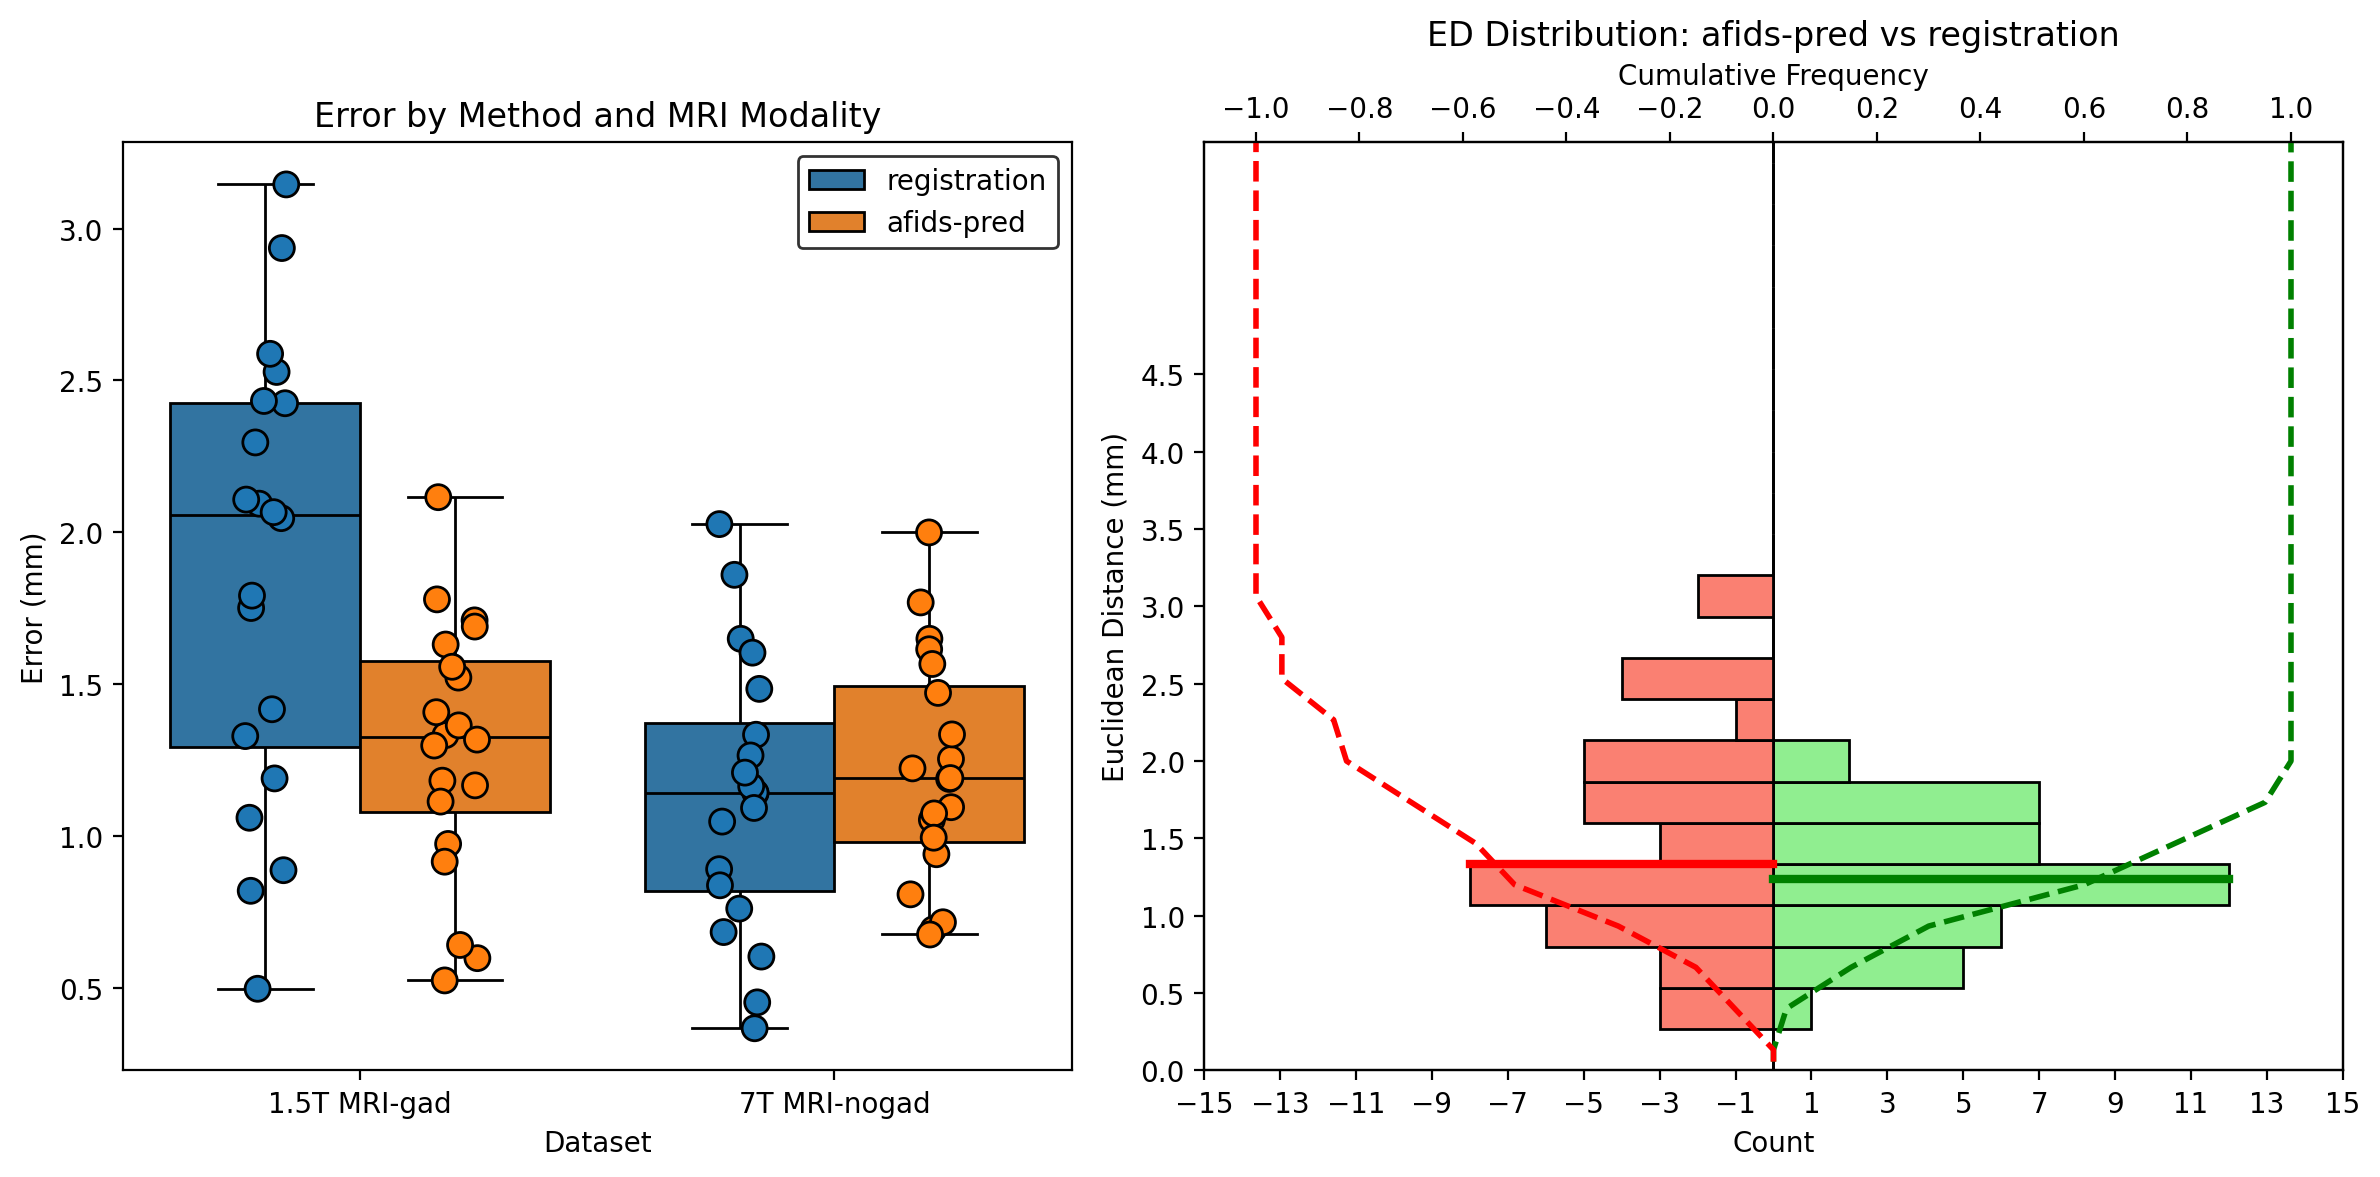

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import wilcoxon

# Combine DataFrames
df_all_clin = pd.concat([df_lead, df_snsxpd1_5t, df_lead_7t, df_snsxpd], ignore_index=True)

# Melt for plotting
melted_all_clin = pd.melt(
    df_all_clin,
    id_vars=["subjectid", "hemisphere", "method", "comparison", "dataset"],
    value_vars=["ED"],
    var_name="metric",
    value_name="error"
)

# ---- Define grouping logic AFTER the left panel is created ----
def simplify_method(method):
    if 'registration' in method:
        return 'registration'
    else:
        return 'afids-pred'

# ---- Create side-by-side plots (left = Box/Strip, right = KDE + CDF) ----
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1, 1.2]})

# ---- LEFT: Stripplot + Boxplot by full method ----
sns.stripplot(
    data=melted_all_clin,
    x="dataset",
    y="error",
    hue="method",
    dodge=True,
    alpha=1,
    size=9,
    jitter=True,
    linewidth=1,
    edgecolor='black',
    legend=False,
    ax=ax1,
)

sns.boxplot(
    data=melted_all_clin,
    x="dataset",
    y="error",
    hue="method",
    dodge=True,
    fliersize=0,
    ax=ax1,
    boxprops=dict(edgecolor='black'),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black'),
    medianprops=dict(color='black'),
    linecolor='black',
    linewidth=1
)

# Clean legend (only show once)
handles, labels = ax1.get_legend_handles_labels()
unique = dict(zip(labels, handles))
leg1 = ax1.legend(unique.values(), unique.keys(), loc="upper right", frameon=True)
leg1.get_frame().set_edgecolor('black')

ax1.set_xlabel("Dataset")
ax1.set_ylabel("Error (mm)")
ax1.set_title("Error by Method and MRI Modality")

# ---- RIGHT: Population Pyramid + Cumulative Frequency using melted_all_clin ----
# Filter relevant methods
melted_all_clin["method_grouped"] = melted_all_clin["method"].apply(simplify_method)

filtered = melted_all_clin[melted_all_clin["method_grouped"].isin(["afids-pred", "registration"])]

# Extract and clip ED data
data_afids = np.clip(filtered[filtered["method_grouped"] == "afids-pred"]["error"].dropna().values, a_min=None, a_max=8)
data_reg = np.clip(filtered[filtered["method_grouped"] == "registration"]["error"].dropna().values, a_min=None, a_max=8)

# Histogram binning
num_bins = 30
counts_afids, bin_edges = np.histogram(data_afids, bins=num_bins, range=(0, 8))
counts_reg, _ = np.histogram(data_reg, bins=num_bins, range=(0, 8))
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Cumulative frequency
counts_afids_cumsum = np.insert(np.cumsum(counts_afids) / np.sum(counts_afids), 0, 0)
counts_reg_cumsum = np.insert(np.cumsum(counts_reg) / np.sum(counts_reg), 0, 0)
bin_centers_cumsum = np.insert(bin_centers, 0, bin_centers[0] - (bin_centers[1] - bin_centers[0]))

# Plot: Population Pyramid
ax2.barh(bin_centers, counts_afids, height=(bin_centers[1] - bin_centers[0]), color='lightgreen', label='afids-pred', edgecolor='black')
ax2.barh(bin_centers, -counts_reg, height=(bin_centers[1] - bin_centers[0]), color='salmon', label='registration', edgecolor='black')

ax2.set_xlabel("Count")
ax2.set_ylabel("Euclidean Distance (mm)")
ax2.set_title("ED Distribution: afids-pred vs registration")

# Twin axis for CDF
ax2b = ax2.twiny()
ax2b.plot(counts_afids_cumsum, bin_centers_cumsum, color='green', linestyle='--', linewidth=2)
ax2b.plot(-counts_reg_cumsum, bin_centers_cumsum, color='red', linestyle='--', linewidth=2)
ax2b.set_xlabel("Cumulative Frequency")

# Median lines
ax2.plot([0, max(counts_afids)], [np.median(data_afids)]*2, color='green', linestyle='-', linewidth=3)
ax2.plot([-max(counts_reg), 0], [np.median(data_reg)]*2, color='red', linestyle='-', linewidth=3)

# Tick formatting
ax2.set_xticks(np.arange(-15, 15+1, 2))
ax2b.set_xticks(np.arange(-1, 1.1, 0.2))
ax2.set_yticks(np.arange(0, 5, 0.5))
ax2b.set_yticks(np.arange(0, 5, 0.5))
ax2.set_ylim(0, 6)
ax2b.set_ylim(0, 6)

# Final layout
plt.tight_layout()
plt.savefig("/Users/alaataha/Documents/GitHub/afids-pred/figures/method_comapre.png", dpi=300)
plt.show()


In [14]:
summary_table, test_table = compute_stats(df_lead_7t, df_snsxpd7t, ['registration','afids-pred'])

print("=== Summary Statistics ===")
print(tabulate(summary_table, headers='keys', tablefmt='grid', showindex=False))

print("\n=== Wilcoxon Test Results ===")
print(tabulate(test_table, headers='keys', tablefmt='grid', showindex=False))

=== Summary Statistics ===
+----------+---------+----------+----------+-------------+-----------+----------+----------+---------+--------------+
| metric   |   count |     mean |      std |         min |       25% |      50% |      75% |     max | dataset      |
+==========+=========+==========+==========+=============+===========+==========+==========+=========+==============+
| MSEx     |      20 | 0.53144  | 0.826014 | 0.00720801  | 0.104792  | 0.2141   | 0.359933 | 3.27733 | registration |
+----------+---------+----------+----------+-------------+-----------+----------+----------+---------+--------------+
| MSEy     |      20 | 0.527406 | 0.662754 | 0.000413309 | 0.0912811 | 0.209764 | 0.865137 | 2.05441 | registration |
+----------+---------+----------+----------+-------------+-----------+----------+----------+---------+--------------+
| MSEz     |      20 | 0.411313 | 0.467535 | 3.22624e-05 | 0.0808763 | 0.225718 | 0.689394 | 1.73375 | registration |
+----------+---------+-------

In [15]:
summary_table, test_table = compute_stats(df_lead, df_snsxpd1_5tv1, ['registration','afids-pred'])

print("=== Summary Statistics ===")
print(tabulate(summary_table, headers='keys', tablefmt='grid', showindex=False))

print("\n=== Wilcoxon Test Results ===")
print(tabulate(test_table, headers='keys', tablefmt='grid', showindex=False))

=== Summary Statistics ===
+----------+---------+----------+----------+------------+-----------+----------+----------+---------+--------------+
| metric   |   count |     mean |      std |        min |       25% |      50% |      75% |     max | dataset      |
+==========+=========+==========+==========+============+===========+==========+==========+=========+==============+
| MSEx     |      20 | 0.830417 | 1.00964  | 0.00426017 | 0.2345    | 0.427227 | 0.991826 | 3.62773 | registration |
+----------+---------+----------+----------+------------+-----------+----------+----------+---------+--------------+
| MSEy     |      20 | 1.99888  | 2.52274  | 0.0045522  | 0.137588  | 0.35954  | 3.72454  | 8.44373 | registration |
+----------+---------+----------+----------+------------+-----------+----------+----------+---------+--------------+
| MSEz     |      20 | 1.18295  | 1.44564  | 0.0161112  | 0.247544  | 0.780889 | 1.46944  | 6.15779 | registration |
+----------+---------+----------+----

## 3. Landmark Prediction Generalizability

In [16]:
# Paths
base_path = '/Users/alaataha/Documents/GitHub/afids-pred/data/coordinate'
afids_path = f'{base_path}/AFIDs'

# Load subject-level AFIDs and concatenate
afids_fcsv = sorted(glob(f'{afids_path}/*/afids_mcp/*/*/*MCP*.fcsv'))

df_subs_afids = pd.concat([afidutils.fcsvtodf(f)[0] for f in afids_fcsv], axis=0)

df_afids_proc = afidutils.flip_and_concatenate_hemispheres(df_subs_afids)

In [17]:
# 1. Identify unique AFID base names (by removing the coordinate suffix).
all_columns = df_afids_proc.columns.tolist()
base_afids = sorted(list(set([col[:-1] for col in all_columns if col[-1] in ['x', 'y', 'z']])))
print("Base AFIDs:", base_afids)

# Dictionary to store results for each base AFID.
results = {}

# Loop over each base AFID for leave-one-out analysis.
for base in base_afids:
    print("============================================")
    print(f"Leave-One-AFID Out Analysis: Excluding AFID: {base}")
    print("============================================")
    
    # 2. Define target columns for the current AFID.
    target_cols = [f"{base}x", f"{base}y", f"{base}z"]
    
    # 3. Define predictors (all other columns) and target.
    predictors_df = df_afids_proc.drop(columns=target_cols)
    target_df = df_afids_proc[target_cols]
    
    # Convert DataFrames to NumPy arrays.
    X_np = predictors_df.to_numpy()   
    y_np = target_df.to_numpy()        
    
    # 4. Define hyperparameters and CV settings.
    alphas = np.logspace(-100, 100, 10000)  # Wide range for RidgeCV.
    outer_folds = 4
    variance_retained = 0.99                # For PCA
    
    # Generate group labels.
    groups = afidutils.create_list(X_np.shape[0] // 2)
    
    # Initialize outer cross-validation.
    outer_cv = GroupKFold(n_splits=outer_folds)
    
    # Lists to store aggregated metrics per fold...
    fold_ED_means = []   # EDs per fold.
    fold_ED_stds = []    # STD of ED per fold.
    
    # New list to store raw (subject-level) ED values for each fold.
    fold_ED_subjects = []  # EDs for the test subjects in that fold.
    
    # List to store best alpha values for each fold.
    best_alpha_values_across_folds = []
    
    # 5. Outer CV loop.
    for fold_idx, (train_index, test_index) in enumerate(outer_cv.split(X_np, groups=groups)):
        print(f"\nFold {fold_idx+1} of {outer_folds}")
        X_train, X_test = X_np[train_index], X_np[test_index]
        y_train, y_test = y_np[train_index], y_np[test_index]
        
        # Get group labels for training (used in inner CV).
        groups_inner = [groups[i] for i in train_index]
        
        # 6. Preprocessing: Scale and apply PCA.
        scaler = StandardScaler()
        pca = PCA(n_components=variance_retained)
        
        X_train_scaled = scaler.fit_transform(X_train)
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_test_pca  = pca.transform(scaler.transform(X_test))
        
        # 7. Inner CV for hyperparameter tuning.
        inner_cv = list(GroupKFold(n_splits=3).split(X_train_pca, groups=groups_inner))
        ridge_cv = RidgeCV(fit_intercept=False, alphas=alphas, scoring='neg_mean_squared_error', cv=inner_cv)
        multi_target_ridge_cv = MultiOutputRegressor(ridge_cv, n_jobs=-1)
        multi_target_ridge_cv.fit(X_train_pca, y_train)
        
        # Save best alphas (optional).
        best_alphas = [est.alpha_ for est in multi_target_ridge_cv.estimators_]
        best_alpha_values_across_folds.append(best_alphas)
        
        # 8. Train final Ridge models using the best alphas.
        ridge_estimators = [
            Ridge(alpha=alpha).fit(X_train_pca, y_train[:, i])
            for i, alpha in enumerate(best_alphas)
        ]
        y_pred = np.column_stack([ridge.predict(X_test_pca) for ridge in ridge_estimators])
        
        # 9. Compute error metrics.
        mse_x = (y_test[:, 0] - y_pred[:, 0]) ** 2
        mse_y = (y_test[:, 1] - y_pred[:, 1]) ** 2
        mse_z = (y_test[:, 2] - y_pred[:, 2]) ** 2
        ED = np.sqrt(mse_x + mse_y + mse_z)  # Subject-level ED values.
        
        print(f"ED combined: {ED.mean():.2f} ± {ED.std():.2f}")
        print(f"MSE x: {mse_x.mean():.2f} ± {mse_x.std():.2f}")
        print(f"MSE y: {mse_y.mean():.2f} ± {mse_y.std():.2f}")
        print(f"MSE z: {mse_z.mean():.2f} ± {mse_z.std():.2f}")
        
        fold_ED_means.append(ED.mean())
        fold_ED_stds.append(ED.std())
        
        # Store the raw subject-level ED values for this fold.
        fold_ED_subjects.append(ED)
    
    # Calculate overall metrics for the current AFID.
    overall_ED_mean = np.mean(fold_ED_means)
    overall_ED_std = np.std(fold_ED_means)
    
    # Store results for this AFID in the results dictionary.
    results[base] = {
        "fold_ED_means": fold_ED_means,
        "fold_ED_stds": fold_ED_stds,
        "fold_ED_subjects": fold_ED_subjects,  # Raw per–subject outputs.
        "overall_ED_mean": overall_ED_mean,
        "overall_ED_std": overall_ED_std,
        "best_alphas": best_alpha_values_across_folds  # Optional.
    }
    
    print(f"\nAFID {base}: Overall ED: {overall_ED_mean:.2f} ± {overall_ED_std:.2f}\n")

print("All results stored in the 'results' dictionary.")


Base AFIDs: ['AC', 'ICS', 'ILMS', 'IMS', 'LVAC', 'LVPC', 'MB', 'PC', 'PMJ', 'SIPF', 'SLMS']
Leave-One-AFID Out Analysis: Excluding AFID: AC

Fold 1 of 4
ED combined: 0.63 ± 0.47
MSE x: 0.00 ± 0.00
MSE y: 0.62 ± 0.81
MSE z: 0.00 ± 0.00

Fold 2 of 4
ED combined: 0.58 ± 0.49
MSE x: 0.00 ± 0.00
MSE y: 0.57 ± 0.85
MSE z: 0.00 ± 0.00

Fold 3 of 4
ED combined: 0.57 ± 0.48
MSE x: 0.00 ± 0.00
MSE y: 0.56 ± 0.92
MSE z: 0.00 ± 0.00

Fold 4 of 4
ED combined: 0.67 ± 0.54
MSE x: 0.00 ± 0.00
MSE y: 0.75 ± 1.35
MSE z: 0.00 ± 0.00

AFID AC: Overall ED: 0.61 ± 0.04

Leave-One-AFID Out Analysis: Excluding AFID: ICS

Fold 1 of 4
ED combined: 1.50 ± 0.74
MSE x: 0.08 ± 0.12
MSE y: 1.38 ± 1.79
MSE z: 1.33 ± 1.80

Fold 2 of 4
ED combined: 1.98 ± 2.10
MSE x: 0.07 ± 0.11
MSE y: 5.71 ± 23.61
MSE z: 2.54 ± 8.76

Fold 3 of 4
ED combined: 1.78 ± 0.87
MSE x: 0.08 ± 0.17
MSE y: 2.46 ± 3.16
MSE z: 1.39 ± 1.90

Fold 4 of 4
ED combined: 1.72 ± 0.86
MSE x: 0.07 ± 0.10
MSE y: 2.41 ± 3.14
MSE z: 1.22 ± 1.59

AFID ICS: Over

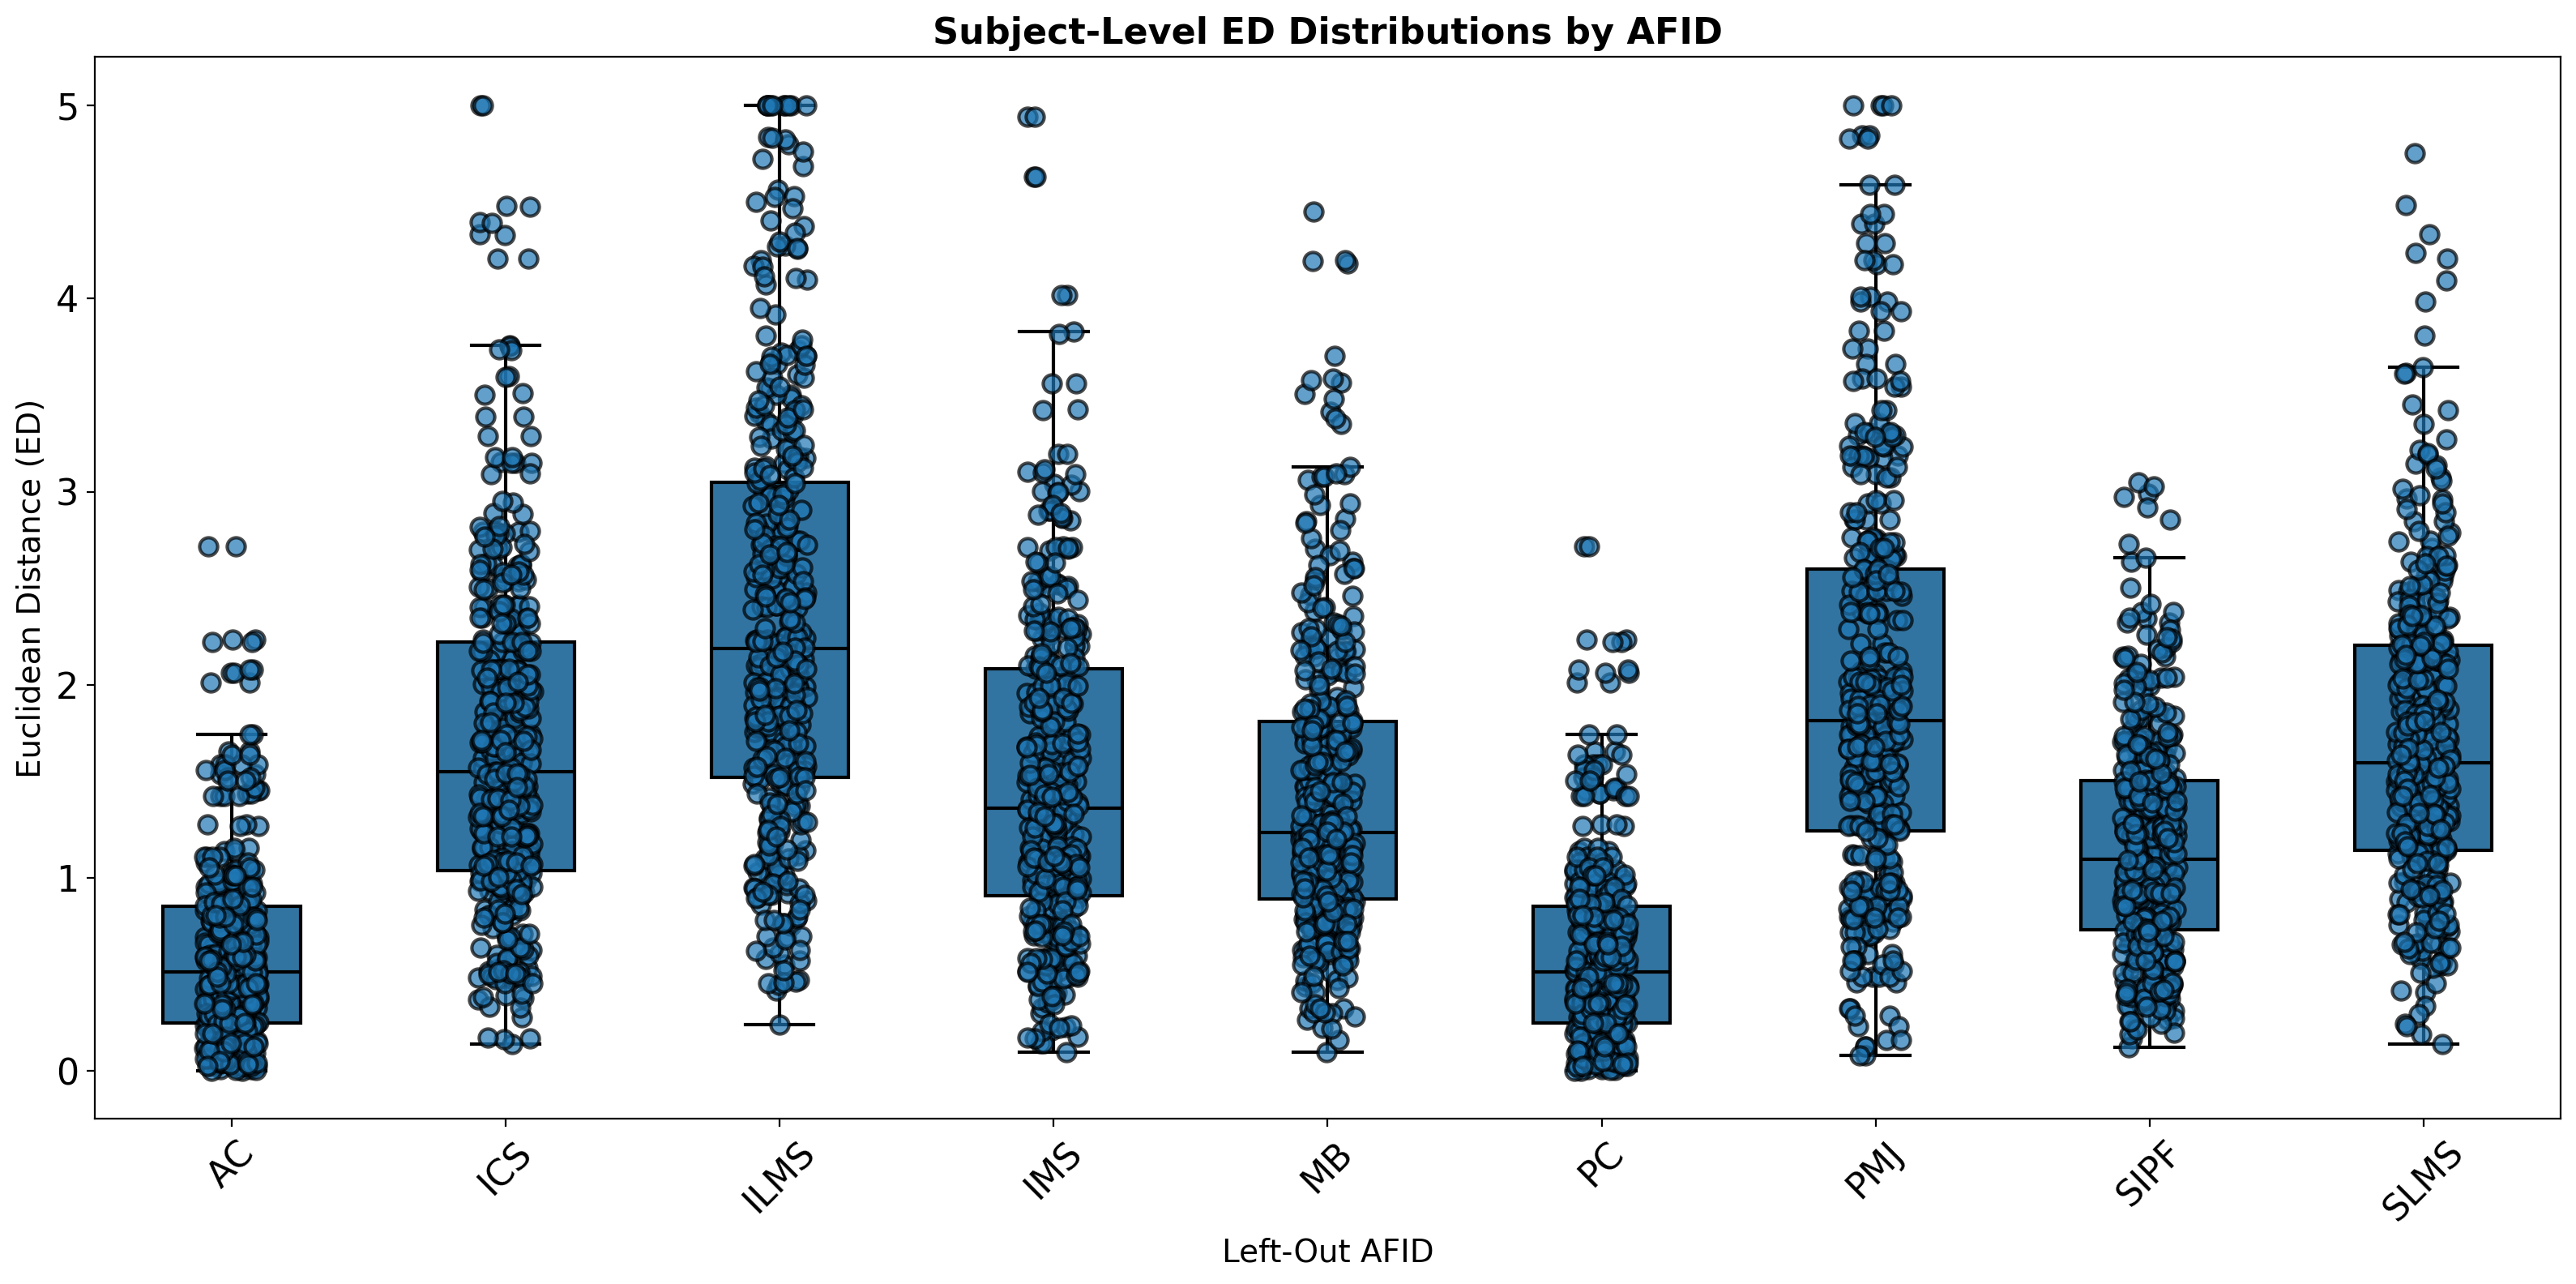

In [21]:
subject_ED_results = {}
for afid in results.keys():
    # Concatenate all folds' ED values into one array per AFID.
    subject_ED_results[afid] = np.concatenate(results[afid]["fold_ED_subjects"])

# Prepare a long-format DataFrame with columns: 'dataset', 'error', and 'method'.
data_rows = []
for afid, ed_array in subject_ED_results.items():
    for ed in ed_array:
        data_rows.append({
            "dataset": afid,  # left-out AFID
            "error": ed,      # subject-level ED
            "method": "Full Method"  # constant method label (adjust if needed)
        })

exclude_landmarks = ['LVAC', 'LVPC']



df_melted = pd.DataFrame(data_rows)
df_melted = df_melted[~df_melted['dataset'].isin(exclude_landmarks)]

cap_value = 5

# Create a new column where error values are capped at cap_value
df_melted['error_capped'] = df_melted['error'].clip(upper=cap_value)

# --- Step 2: Generate the combined stripplot and boxplot using seaborn ---
# Create the figure and axis.
fig, ax = plt.subplots(figsize=(16, 8))

# Create a stripplot to show individual data points.

sns.stripplot(
    data=df_melted,
    x="dataset",
    y="error_capped",
    dodge=True,
    alpha=0.7,
    size=8,
    jitter=True,
    linewidth=1.5,
    edgecolor='black',
    legend=False,
    ax=ax,
)
# Create a boxplot to show the summary statistics.
sns.boxplot(
    data=df_melted,
    x="dataset",
    y="error_capped",
    hue="method",
    dodge=True,
    fliersize=0,
    ax=ax,
    boxprops=dict(edgecolor='black',linewidth=1.5),
    whiskerprops=dict(color='black',linewidth=1.5),
    capprops=dict(color='black',linewidth=1.5),
    medianprops=dict(color='black',linewidth=1.5),
    linewidth=1.5,
    width=0.5
)
# Optionally, remove the duplicate legend if present.
ax.legend_.remove()

# Set labels and title.
ax.set_xlabel("Left-Out AFID", fontsize=14)
ax.set_ylabel("Euclidean Distance (ED)", fontsize=14)
ax.set_title("Subject-Level ED Distributions by AFID", fontsize=16, fontweight="bold")
plt.xticks(fontsize=16, rotation=45)
plt.yticks(fontsize=16)
plt.tight_layout()

# Save the figure.
plt.savefig("/Users/alaataha/Documents/GitHub/afids-pred/figures/landmark_generalizability_seaborn.png", dpi=300)
plt.show()


In [19]:
df_melted.describe()

,error,error_capped
count,3636.000000,3636.000000
mean,1.465409,1.465409
std,1.092222,1.092222
min,0.001571,0.001571
25%,0.732887,0.732887
50%,1.267733,1.267733
75%,1.998167,1.998167
max,16.716421,16.716421
